
# Линейная регрессия. Практическая работа

## Цель практической работы

Научиться строить модель линейной регрессии на реальных данных.

## Что входит в практическую работу


1. Загрузить данные и ознакомиться с ними.
2. Изучить данные и провести анализ.
3. Разделить данные на обучающую и тестовую выборки.
4. Реализовать построение модели с помощью  библиотеки scikit-learn.
5. Получить качество модели с помощью MSE, MAE.


## Что оценивается 

* Выполнены все этапы работы.
* Сделан вывод по результатам.
* Модель не переобучена.
* Получена модель хорошего качества.

## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задачи. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.



## Что нужно сделать

Пусть у нас имеется некоторый набор данных `sales.csv` о продажах квартир:

- **SalePrice** (цена продажи, *зависимая переменная*).
- **GrLivArea** (наземная жилая зона).
- **OverallQuality** (общее качество).
- **GarageArea** (территория гаража).
- **SaleCondition** (условия сделки).

Реализуйте построение модели линейной регрессии на этих данных. Проверьте качество модели на обучающей и тестовой выборках с помощью MAE, MSE. Определите, что вы не переобучились.

### 1. Импорт библиотек

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### 2. Загрузка данных

In [133]:
df = pd.read_csv('data/sales.csv')
print(df.columns)
print(df.shape)
print(df.dtypes)
df.head(10)

Index(['SalePrice', 'GrLivArea', 'GarageArea', 'OverallQual', 'Street',
       'SaleCondition'],
      dtype='object')
(1460, 6)
SalePrice         int64
GrLivArea         int64
GarageArea        int64
OverallQual       int64
Street           object
SaleCondition    object
dtype: object


,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
0,208500,1710,548,7,Pave,Normal
1,181500,1262,460,6,Pave,Normal
2,223500,1786,608,7,Pave,Normal
3,140000,1717,642,7,Pave,Abnorml
4,250000,2198,836,8,Pave,Normal
5,143000,1362,480,5,Pave,Normal
6,307000,1694,636,8,Pave,Normal
7,200000,2090,484,7,Pave,Normal
8,129900,1774,468,7,Pave,Abnorml
9,118000,1077,205,5,Pave,Normal


### 3. Первичный анализ

1. Проведите анализ данных, посмотрите на индивидуальные графики зависимости целевой функции и отдельной переменной. Нередко, если признаков в выборке не так много, удобно построить [sns.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html).
2. Закодируйте категориальные признаки (например, с помощью [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)).
3. Подумайте, можно ли здесь создать дополнительные переменные из имеющихся.
4. Сделайте предварительные выводы.

In [134]:
df['SalePrice'].value_counts()

SalePrice
140000    20
135000    17
155000    14
145000    14
190000    13
          ..
202665     1
164900     1
208300     1
181500     1
147500     1
Name: count, Length: 663, dtype: int64

In [135]:
# дубликаты
sum(df.duplicated())

1

In [136]:
# Удалим дубликаты
df.drop_duplicates(inplace=True)

In [137]:
# пропуски
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
missing_values

SalePrice        0.0
GrLivArea        0.0
GarageArea       0.0
OverallQual      0.0
Street           0.0
SaleCondition    0.0
dtype: float64

In [138]:
# снова посмотрим на наши данные и их значения
for i in list(df):
    print('Характеристика:', i)
    print('type', df[i].dtype)
    print('Количество уникальных значений:', df[i].nunique())
    print(':-)')

Характеристика: SalePrice
type int64
Количество уникальных значений: 663
:-)
Характеристика: GrLivArea
type int64
Количество уникальных значений: 861
:-)
Характеристика: GarageArea
type int64
Количество уникальных значений: 441
:-)
Характеристика: OverallQual
type int64
Количество уникальных значений: 10
:-)
Характеристика: Street
type object
Количество уникальных значений: 2
:-)
Характеристика: SaleCondition
type object
Количество уникальных значений: 6
:-)


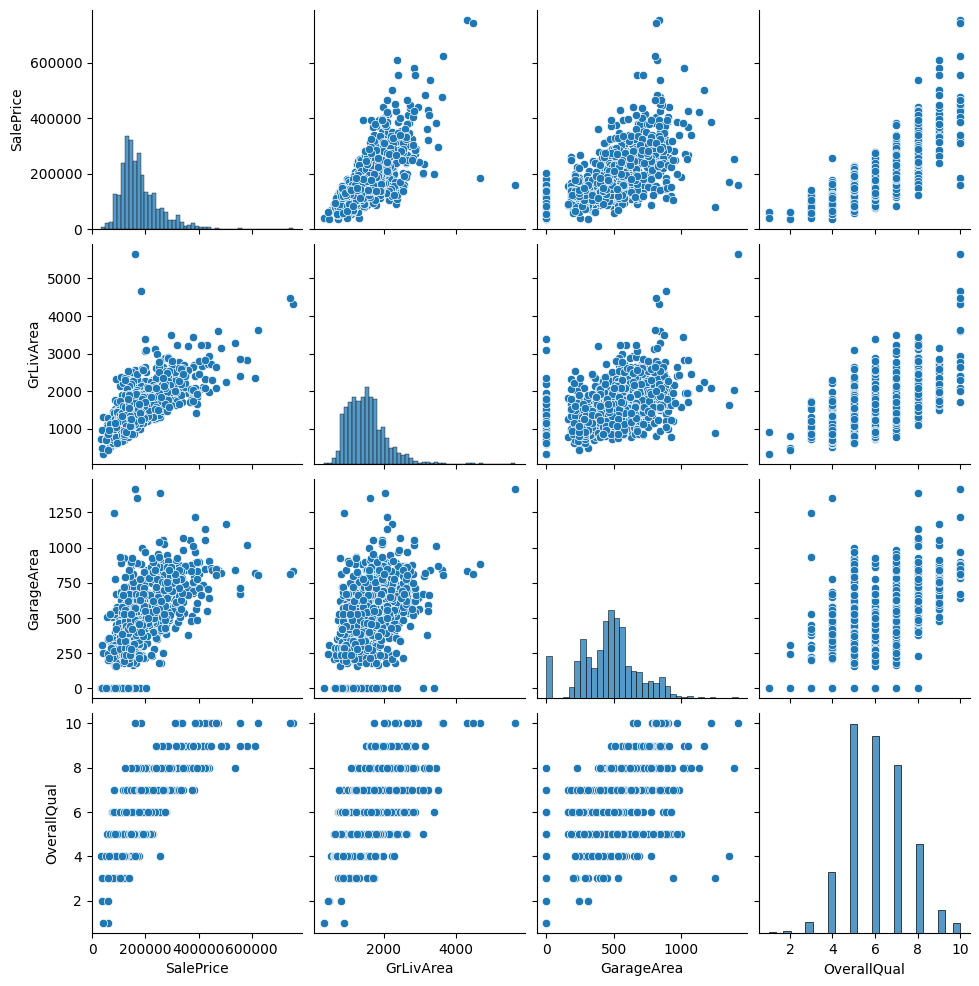

In [139]:
sns.pairplot(df)

Посмотрим выбросы

In [140]:


def quantiles(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75) # квантиль
    iqr = q75 - q25 #размах
    quantil_column = (int(q25 - 1.5 * iqr), int(q75 + 1.5 * iqr))

    return quantil_column



In [141]:
# выберем численные признаки
df_quant = df.drop(['Street', 'SaleCondition'], axis=1)

Посмотрим количество выбросов в признакакх слева и справа

In [142]:
for i in df_quant.columns:
    quantil = quantiles(df_quant[i])
    is_outlier_right = sum(df_quant[i] > quantil[1])
    is_outlier_left = sum(df_quant[i] < quantil[0])
    print(i, is_outlier_left, is_outlier_right)

SalePrice 0 61
GrLivArea 0 31
GarageArea 0 21
OverallQual 2 0


Поскольку модель линейной регрессии довольно чувствительна к выбросам в признаках. Выбросы могут значительно искажать оценки коэффициентов регрессии и повлиять на предсказания модели. Поэтому перед построением модели линейной регрессии важно провести анализ данных на наличие выбросов и рассмотреть возможные способы их обработки, например, удаление выбросов, замена на среднее значение или медиану и т.д. Другие методы регрессии, такие как робастная линейная регрессия, могут быть более устойчивыми к выбросам и использоваться в случае, если данные содержат выбросы.

Изменим значения выбросов в признаках на граничные значения кванилей

In [143]:
quantil = quantiles(df['SalePrice'])
df['SalePrice'] = np.where(df['SalePrice'] > quantil[1], quantil[1], df['SalePrice'])
print(df['SalePrice'].value_counts())
print(quantiles(df['SalePrice']))


SalePrice
340075    61
140000    20
135000    17
145000    14
155000    14
          ..
315750     1
184750     1
106250     1
265000     1
147500     1
Name: count, Length: 606, dtype: int64
(3875, 340075)


In [144]:
quantil = quantiles(df['GrLivArea'])
df['GrLivArea'] = np.where(df['GrLivArea'] > quantil[1], quantil[1], df['GrLivArea'])
print(df['GrLivArea'].value_counts())
print(quantiles(df['GrLivArea']))

GrLivArea
2750    31
864     22
1040    14
894     11
1456    10
        ..
2296     1
1199     1
1586     1
1473     1
1256     1
Name: count, Length: 832, dtype: int64
(156, 2750)


In [145]:
quantil = quantiles(df['GarageArea'])
df['GarageArea'] = np.where(df['GarageArea'] > quantil[1], quantil[1], df['GarageArea'])
print(df['GarageArea'].value_counts())
print(quantiles(df['GarageArea']))

GarageArea
0      81
440    49
576    47
240    38
484    34
       ..
842     1
816     1
230     1
261     1
192     1
Name: count, Length: 423, dtype: int64
(-31, 940)


In [146]:
quantil = quantiles(df['OverallQual'])
df['OverallQual'] = np.where(df['OverallQual'] < quantil[0], quantil[0], df['OverallQual'])
print(df['OverallQual'].value_counts())
print(quantiles(df['OverallQual']))

OverallQual
5     397
6     374
7     318
8     168
4     116
9      43
3      20
10     18
2       5
Name: count, dtype: int64
(2, 10)


In [147]:
# Проверим что у нас получилось
df_quant = df.drop(['Street', 'SaleCondition'], axis=1)

for i in df_quant.columns:
    quantil = quantiles(df_quant[i])
    is_outlier_right = sum(df_quant[i] > quantil[1])
    is_outlier_left = sum(df_quant[i] < quantil[0])
    print(i, is_outlier_left, is_outlier_right)

SalePrice 0 0
GrLivArea 0 0
GarageArea 0 0
OverallQual 0 0


In [148]:
df_next = df

Посмотрим на корреляцию к целевой переменной

In [149]:
# создаем временный датасет
# преобразуем данные
df_sur = df.copy() # создаем копию!
for i in df_sur.columns:
    df_sur[i] = df_sur[i].astype('category').cat.codes
#print(df_sur.dtypes)
# выводим корреляцию
col_min_corr = []
for i in df_sur.columns:
    j = df_sur[i]
    corr = df_sur['SalePrice'].corr(j)
    if -0.001 < corr and corr < 0.001:
        col_min_corr.append(i)


    print('corr', i, round(df_sur['SalePrice'].corr(j), 6), 'to_SalePrice')

print('min_corr', col_min_corr)

corr SalePrice 1.0 to_SalePrice
corr GrLivArea 0.735857 to_SalePrice
corr GarageArea 0.661931 to_SalePrice
corr OverallQual 0.814838 to_SalePrice
corr Street 0.044024 to_SalePrice
corr SaleCondition 0.235634 to_SalePrice
min_corr []


In [150]:
df_corr = df_sur.corr()
df_corr

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
SalePrice,1.000000,0.735857,0.661931,0.814838,0.044024,0.235634
GrLivArea,0.735857,1.000000,0.480660,0.600798,0.047278,0.100352
GarageArea,0.661931,0.480660,1.000000,0.567668,-0.038890,0.164906
OverallQual,0.814838,0.600798,0.567668,1.000000,0.059062,0.194490
Street,0.044024,0.047278,-0.038890,0.059062,1.000000,0.006055
SaleCondition,0.235634,0.100352,0.164906,0.194490,0.006055,1.000000


Визуализируем корреляции

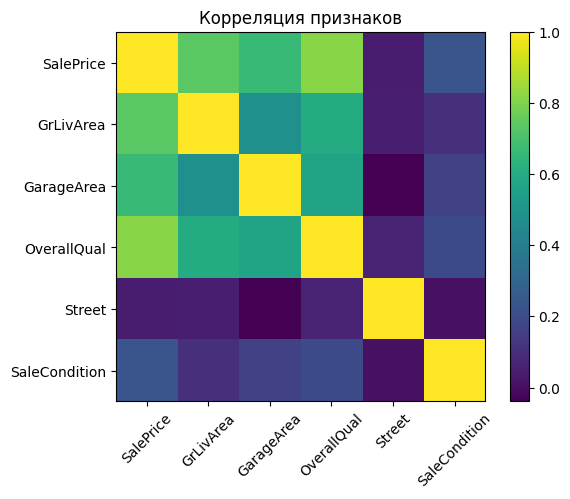

In [151]:
columns = df_sur.corr().columns.tolist()
plt.imshow(df_sur.corr())

plt.title("Корреляция признаков")
plt.xticks(range(0, len(columns)), columns, rotation=45)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

### 3.2 Поработаем с категориальными признаками

In [152]:
df.dtypes

SalePrice         int64
GrLivArea         int64
GarageArea        int64
OverallQual       int64
Street           object
SaleCondition    object
dtype: object

In [153]:
# Применяем One-Hot Encoding с помощью pd.get_dummies
encoded_df = pd.get_dummies(df['Street'], prefix='Street')
# Объединяем исходный датафрейм и закодированные признаки
df = pd.concat([df, encoded_df], axis=1)
print(df)

      SalePrice  GrLivArea  GarageArea  OverallQual Street SaleCondition  \
0        208500       1710         548            7   Pave        Normal   
1        181500       1262         460            6   Pave        Normal   
2        223500       1786         608            7   Pave        Normal   
3        140000       1717         642            7   Pave       Abnorml   
4        250000       2198         836            8   Pave        Normal   
...         ...        ...         ...          ...    ...           ...   
1455     175000       1647         460            6   Pave        Normal   
1456     210000       2073         500            6   Pave        Normal   
1457     266500       2340         252            7   Pave        Normal   
1458     142125       1078         240            5   Pave        Normal   
1459     147500       1256         276            5   Pave        Normal   

      Street_Grvl  Street_Pave  
0           False         True  
1           False    

In [154]:
df = df.drop(['Street'], axis=1)

In [155]:
encoded_df = pd.get_dummies(df['SaleCondition'], prefix='SaleCondition')
# Объединяем исходный датафрейм и закодированные признаки
df = pd.concat([df, encoded_df], axis=1)
print(df)

      SalePrice  GrLivArea  GarageArea  OverallQual SaleCondition  \
0        208500       1710         548            7        Normal   
1        181500       1262         460            6        Normal   
2        223500       1786         608            7        Normal   
3        140000       1717         642            7       Abnorml   
4        250000       2198         836            8        Normal   
...         ...        ...         ...          ...           ...   
1455     175000       1647         460            6        Normal   
1456     210000       2073         500            6        Normal   
1457     266500       2340         252            7        Normal   
1458     142125       1078         240            5        Normal   
1459     147500       1256         276            5        Normal   

      Street_Grvl  Street_Pave  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0           False         True                  False                  False   
1          

In [156]:
df = df.drop(['SaleCondition'], axis=1)
df.columns

Index(['SalePrice', 'GrLivArea', 'GarageArea', 'OverallQual', 'Street_Grvl',
       'Street_Pave', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object')

Оч захотелось снова взглянуть на корреляции

In [157]:
df.corr()

,SalePrice,GrLivArea,GarageArea,OverallQual,Street_Grvl,Street_Pave,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
SalePrice,1.000000,0.729262,0.660068,0.818017,-0.045093,0.045093,-0.141352,-0.057129,-0.015663,-0.048681,-0.127871,0.339511
GrLivArea,0.729262,1.000000,0.471473,0.597663,-0.046627,0.046627,-0.054601,-0.042637,0.030407,-0.005643,-0.077735,0.156624
GarageArea,0.660068,0.471473,1.000000,0.568218,0.031271,-0.031271,-0.096929,-0.103944,-0.004626,-0.015388,-0.122446,0.283135
OverallQual,0.818017,0.597663,0.568218,1.000000,-0.059062,0.059062,-0.104045,-0.041850,-0.045156,-0.025668,-0.143533,0.324256
Street_Grvl,-0.045093,-0.046627,0.031271,-0.059062,1.000000,-1.000000,-0.017525,-0.003369,0.112731,-0.007576,0.002161,-0.019671
Street_Pave,0.045093,0.046627,-0.031271,0.059062,-1.000000,1.000000,0.017525,0.003369,-0.112731,0.007576,-0.002161,0.019671
SaleCondition_Abnorml,-0.141352,-0.054601,-0.096929,-0.104045,-0.017525,0.017525,1.000000,-0.014299,-0.024835,-0.032151,-0.582918,-0.083481
SaleCondition_AdjLand,-0.057129,-0.042637,-0.103944,-0.041850,-0.003369,0.003369,-0.014299,1.000000,-0.004775,-0.006181,-0.112071,-0.016050
SaleCondition_Alloca,-0.015663,0.030407,-0.004626,-0.045156,0.112731,-0.112731,-0.024835,-0.004775,1.000000,-0.010736,-0.194649,-0.027876
SaleCondition_Family,-0.048681,-0.005643,-0.015388,-0.025668,-0.007576,0.007576,-0.032151,-0.006181,-0.010736,1.000000,-0.251989,-0.036088


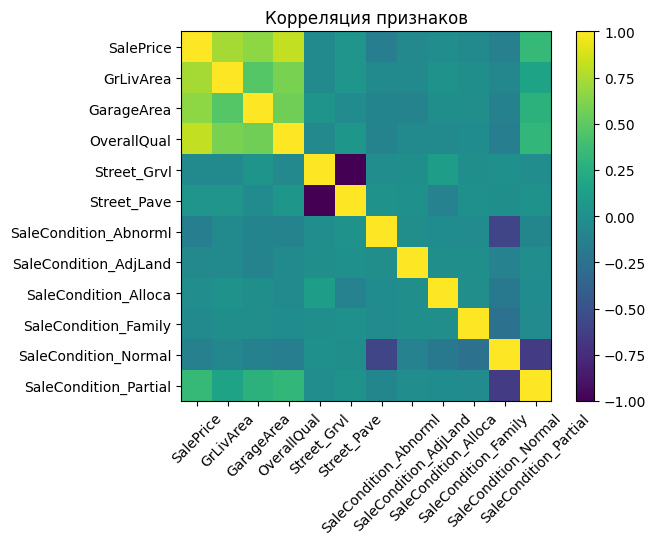

In [158]:
columns = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title("Корреляция признаков")
plt.xticks(range(0, len(columns)), columns, rotation=45)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

### 4. Разделение на обучающую и тестовую выборки

In [159]:
print(df.shape)
df.dtypes

(1459, 12)


SalePrice                int64
GrLivArea                int64
GarageArea               int64
OverallQual              int64
Street_Grvl               bool
Street_Pave               bool
SaleCondition_Abnorml     bool
SaleCondition_AdjLand     bool
SaleCondition_Alloca      bool
SaleCondition_Family      bool
SaleCondition_Normal      bool
SaleCondition_Partial     bool
dtype: object

In [160]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### 5. Обучение модели линейной регрессии

Дополнительно можно взглянуть на коэффициенты и смещение обученной модели.

In [161]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

Посмотрим коэффиценты

In [162]:
w_0 = model.intercept_ 
w_0

-61114.64648672301

In [163]:
w_1 = model.coef_
w_1

array([    46.49248531,     67.37514589,  22636.87696446,   2964.7556748 ,
        -2964.7556748 , -12591.81540869,  -4392.3433507 ,  15569.84969008,
       -19705.16561453,    396.06432824,  20723.4103556 ])

Дополнительно, можно построить график значений коэффициентов для каждого признака:

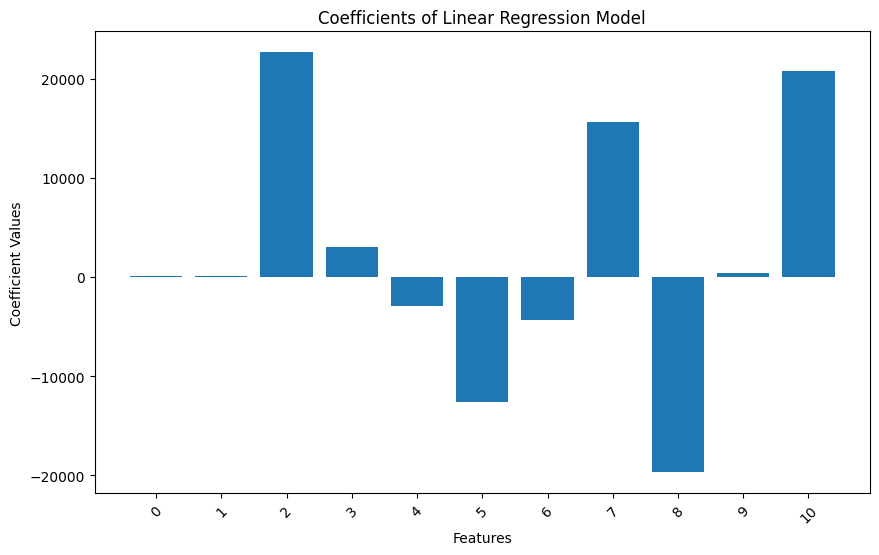

In [164]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(model.coef_)), model.coef_)
plt.xticks(range(len(model.coef_)), rotation=45)
plt.xlabel("Features")
plt.ylabel("Coefficient Values")
plt.title("Coefficients of Linear Regression Model")
plt.show()


### 6. Получение предсказаний для обучающей и тестовой выборок

In [165]:
pred_formula = model.intercept_ + model.coef_ * x_train
pred_formula[:5]

,GrLivArea,GarageArea,OverallQual,Street_Grvl,Street_Pave,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,17085.713803,-25405.819168,97343.492265,-61114.646487,-64079.402162,-61114.646487,-61114.646487,-61114.646487,-61114.646487,-60718.582158,-61114.646487
1452,-11274.702236,-25742.694897,52069.738336,-61114.646487,-64079.402162,-61114.646487,-61114.646487,-61114.646487,-61114.646487,-60718.582158,-61114.646487
1047,-15087.086031,-15838.548452,52069.738336,-61114.646487,-64079.402162,-61114.646487,-61114.646487,-61114.646487,-61114.646487,-60718.582158,-61114.646487
691,66739.688113,-5058.525110,165254.123158,-61114.646487,-64079.402162,-61114.646487,-61114.646487,-61114.646487,-61114.646487,-60718.582158,-61114.646487
435,16109.371611,-24058.316250,97343.492265,-61114.646487,-64079.402162,-61114.646487,-61114.646487,-61114.646487,-61114.646487,-60718.582158,-61114.646487


### 7. Проверка предсказаний

1. Проверьте качество модели на обучающей и тестовой выборках с помощью MAE, MSE.
2. Постройте диаграмму рассеяния целевой и предсказанной переменных. 

In [166]:
y_predict_train = model.predict(x_train)
y_predict_test = model.predict(x_test)

In [167]:
train_mae = mean_absolute_error(y_train, y_predict_train)
test_mae = mean_absolute_error(y_test, y_predict_test)
print("Train MAE: {}".format(train_mae))
print("Test MAE: {}".format(test_mae))

Train MAE: 22549.999157124093
Test MAE: 22339.479100744014


In [168]:
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 940500555.1652777
Test MSE: 836399968.433751


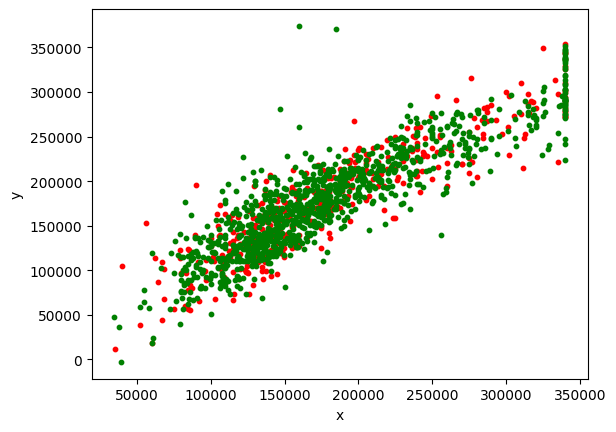

In [169]:

plt.scatter(y_test, y_predict_test, s=10, c='r')
plt.scatter(y_train, y_predict_train, s=10, c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Попоробуем улучшить модель, поработаем с признаками

возьмем датасет с этапа после очистки выбросов

и вернемся к кореляции признаков

Из полученной матрицы корреляции видно:

 что некоторые признаки сильно коррелируют друг с другом. Например, SalePrice сильно коррелирует с GrLivArea (0.74) и OverallQual (0.82). GarageArea и OverallQual также имеют довольно высокую корреляцию (0.57).

Мультиколлинеарность возникает, когда два или более предиктора в модели сильно коррелированы между собой. Она может привести к нестабильным оценкам коэффициентов и затруднить интерпретацию результатов модели.

В данном случае, можно отказаться от признака GrLivArea, так как он сильно коррелирует с SalePrice и может привести к мультиколлинеарности в модели. Выбор между двумя сильно коррелированными признаками (GrLivArea и GarageArea) обычно зависит от целей анализа.

Также стоит учитывать, что признак Street имеет очень слабую корреляцию с SalePrice (0.043), что может указывать на то, что он слабо влияет на целевую переменную и может нести мало информации для модели. В этом случае, его также можно исключить из обучающего набора данных.

В итоге, для обучения модели линейной регрессии и избежания мультиколлинеарности стоит отказаться от признаков GrLivArea и Street.

In [170]:
df_next2 = df_next
df_next.dtypes

SalePrice         int64
GrLivArea         int64
GarageArea        int64
OverallQual       int64
Street           object
SaleCondition    object
dtype: object

In [171]:
df_next = df_next.drop(['GrLivArea', 'Street'], axis=1)

In [172]:
encoded_df = pd.get_dummies(df_next['SaleCondition'], prefix='SaleCondition')
# Объединяем исходный датафрейм и закодированные признаки
df_next = pd.concat([df_next, encoded_df], axis=1)
df_next = df_next.drop(['SaleCondition'], axis=1)
print(df_next.shape)
df_next.columns

(1459, 9)


Index(['SalePrice', 'GarageArea', 'OverallQual', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object')

In [173]:
X = df_next.drop('SalePrice', axis=1)
y = df_next['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [174]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [175]:
y_predict_train = model.predict(x_train)
y_predict_test = model.predict(x_test)

train_mae = mean_absolute_error(y_train, y_predict_train)
test_mae = mean_absolute_error(y_test, y_predict_test)
print("Train MAE: {}".format(train_mae))
print("Test MAE: {}".format(test_mae))

train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MAE: 26403.275564329244
Test MAE: 27150.07319160556
Train MSE: 1238148340.7692132
Test MSE: 1192523634.6502385


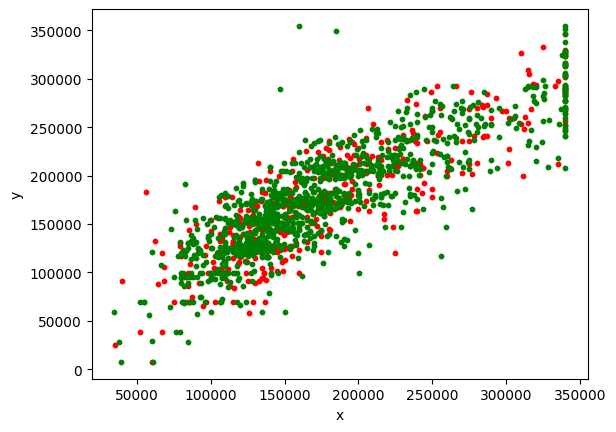

In [176]:
plt.scatter(y_test, y_predict_test, s=10, c='r')
plt.scatter(y_train, y_predict_train, s=10, c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [177]:
df_next = df_next2
df_next = df_next.drop(['OverallQual', 'Street'], axis=1)

encoded_df = pd.get_dummies(df_next['SaleCondition'], prefix='SaleCondition')
# Объединяем исходный датафрейм и закодированные признаки
df_next = pd.concat([df_next, encoded_df], axis=1)
df_next = df_next.drop(['SaleCondition'], axis=1)

X = df_next.drop('SalePrice', axis=1)
y = df_next['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


model = LinearRegression()
model.fit(x_train, y_train)


y_predict_train = model.predict(x_train)
y_predict_test = model.predict(x_test)

train_mae = mean_absolute_error(y_train, y_predict_train)
test_mae = mean_absolute_error(y_test, y_predict_test)
print("Train MAE: {}".format(train_mae))
print("Test MAE: {}".format(test_mae))

train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MAE: 27909.60772666645
Test MAE: 27223.21372073471
Train MSE: 1449011431.673067
Test MSE: 1332161978.8473818


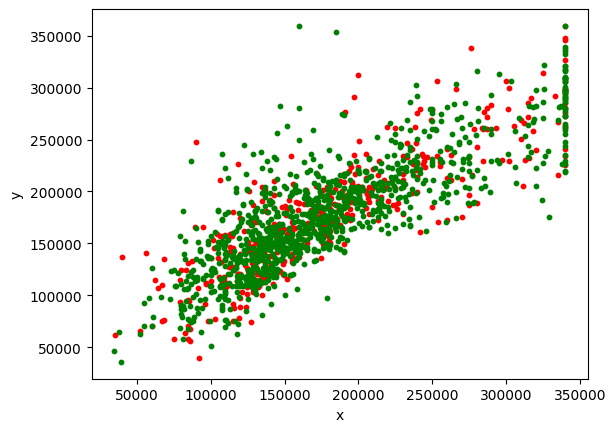

In [178]:
plt.scatter(y_test, y_predict_test, s=10, c='r')
plt.scatter(y_train, y_predict_train, s=10, c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [179]:
df_next = df_next2
df_next = df_next.drop(['SaleCondition', 'Street'], axis=1)


X = df_next.drop('SalePrice', axis=1)
y = df_next['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


model = LinearRegression()
model.fit(x_train, y_train)


y_predict_train = model.predict(x_train)
y_predict_test = model.predict(x_test)

train_mae = mean_absolute_error(y_train, y_predict_train)
test_mae = mean_absolute_error(y_test, y_predict_test)
print("Train MAE: {}".format(train_mae))
print("Test MAE: {}".format(test_mae))

train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MAE: 23170.37227025439
Test MAE: 22097.4288789927
Train MSE: 989651305.1584524
Test MSE: 827754379.3832712


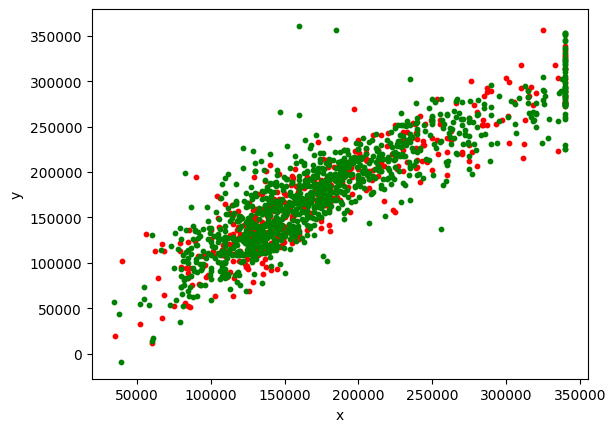

In [180]:
plt.scatter(y_test, y_predict_test, s=10, c='r')
plt.scatter(y_train, y_predict_train, s=10, c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()